In [1]:
% load_ext rpy2.ipython

In [2]:
%%R
#ip <- installed.packages() 
#pkgs.to.remove <- ip[!(ip[,"Priority"] %in% c("base", "recommended")), 1]
#sapply(pkgs.to.remove, remove.packages)

NULL


In [3]:
%%R
#source("http://bioconductor.org/biocLite.R")

NULL


In [4]:
%%R
#biocLite("phyloseq")

NULL


In [5]:
%%R
#source("http://bioconductor.org/biocLite.R")
#biocLite("phyloseq")

NULL


In [25]:
%%R
library("phyloseq")

In [7]:
%%R
library(ggplot2)

In [71]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [72]:
%%R
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4857 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 4857 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4857 tips and 4855 internal nodes ]


In [10]:
%%R
ps.b = subset_taxa(physeq,Kingdom=="Bacteria")
ps.b = subset_samples(ps.b,sample_sums(physeq)>2000)

In [73]:
%%R
physeq.noK <- subset_samples(physeq,Trtmt!="K")

In [74]:
%%R
physeq.noSmall<-subset_samples(physeq,sample_sums(physeq)>5000)

In [89]:
%%R
physeq.buff <- subset_samples(physeq,(MyID==67|MyID==68|MyID==69|MyID==70|MyID==71|MyID==72|MyID==73|MyID==74|MyID==75|MyID==76|MyID==77))
#Making physeq with only the PCR replicated data

In [75]:
%%R
physeq.noSmall.FQ <- subset_samples(physeq,sample_sums(physeq)>1000)
physeq.noSmall.FQ <- subset_samples(physeq.noSmall.FQ,Trtmt==c("Q","F"))

In [90]:
%%R
ps.no2 <- subset_samples(physeq,Month!=2)

In [91]:
%%R
ps <- physeq.buff

In [92]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
ps_snorm = transform_sample_counts(ps, function(x) x / sum(x))

In [96]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

ord.NMDS.full = ordinate(ps_snorm, method = "PCoA", distance = "unifrac", weighted=TRUE)
NMDS.full = plot_ordination(ps_snorm, ord.NMDS.full, axes = c(1,2), justDF = TRUE)
NMDS.full$Samples = rownames(NMDS.full)

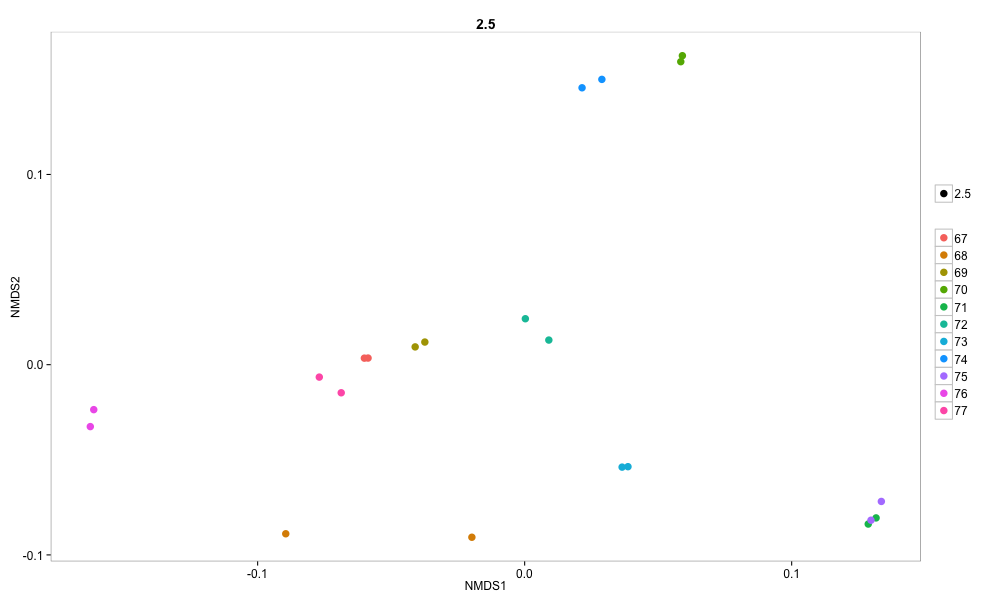

In [97]:
%%R -h 600 -w 1000
D <- NMDS.full
# Sets the relevant ordination

#D$Trtmt <- as.factor(D$Trtmt)
#levels(D$Trtmt) <- c("Ferrihydrite", "Heavy Fraction", "Kaolinite", "Quartz", "Soil")

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

#D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
#D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
#D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = MyID, shape = Month))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) 
#+ scale_colour_manual(values=c("skyblue3","orange","chartreuse4","gold1","red3","black"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),axis.text = element_text(size=12),legend.text = element_text(size=12),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~Month, scales="free")
# The axis scales could be all optimized individually
# p = p + facet_grid(~Month)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
#plot.full.byDay = p
p